## **ECG Diagnosis Code**

This code is based on the code developed here: https://doi.org/10.1038/s41467-020-15432-4

**Define Libraries**

In [71]:
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.decomposition import SparseCoder, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, make_scorer
import matplotlib.pyplot as plt
import numpy as np
import h5py
import math
import pandas as pd
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import pickle
import neurokit2 as nk
from scipy.signal import welch
import time

In [72]:
cwd = os.getcwd()

if not os.path.exists(cwd + '\\outputs\\'):
    os.makedirs(cwd + '\\outputs\\')

**Load the data**

First Load in the test data

In [73]:
#Load in test data
path_to_hdf5 = cwd + '\\data\\ecg_tracings.hdf5'
dataset_name = 'tracings'
path_to_csv = cwd + '\\data\\gold_standard.csv'

#Order is based on test set csv
abnormalities = ['1dAVb','RBBB', 'LBBB', 'SB',  'AF', 'ST']

labels_test = pd.read_csv(path_to_csv).values
f = h5py.File(path_to_hdf5, "r")
tracings_test = f[dataset_name][()]
f.close()
fs = 400 #Hz

Investigation of the class probabilities in the test set (this is done in the study as well)

Text(0.5, 0, 'Cardiac Abnormality')

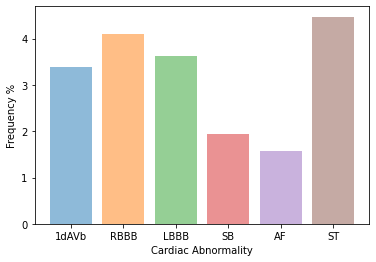

In [74]:
def FindPercents(labels:np.ndarray, average: bool=True):
    bias = []
    for ii in range(labels.shape[-1]):
        bias.append(np.sum(labels[:,ii])/len(labels[:,ii]))
    
    if average:
        bias = np.mean(bias)
        return bias
    else:
        return np.array(bias)

test_per = FindPercents(labels_test, average=False)
for ii, cardiac_class in enumerate(abnormalities):
    plt.bar(cardiac_class, test_per[ii]*100, alpha = 0.5, align = 'center')
plt.ylabel('Frequency %')
plt.xlabel('Cardiac Abnormality')

**Saving Data Functions**

A function for saving data

In [75]:
def SaveObject(object_to_save, save_path):
    '''Load path must have the file name with the .pickle extension'''
    pickle_out = open(save_path, 'wb')
    pickle.dump(object_to_save, pickle_out)
    pickle_out.close()

Function for loading data

In [76]:
def LoadObject(load_path):
    infile = open(load_path, 'rb')
    Loaded_object = pickle.load(infile)
    infile.close()

    return Loaded_object

## Current Model

**Define the NN model**

In [77]:
class ResidualUnit(object):
    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_keep_prob=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = 1 - dropout_keep_prob
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1]
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2]
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


def get_model(n_classes, last_layer='sigmoid'):
    kernel_size = 16
    kernel_initializer = 'he_normal'
    signal = Input(shape=(4096, 12), dtype=np.float32, name='signal')
    x = signal
    x = Conv1D(64, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x, y = ResidualUnit(1024, 128, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, x])
    x, y = ResidualUnit(256, 196, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, y = ResidualUnit(64, 256, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, _ = ResidualUnit(16, 320, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x = Flatten()(x)
    diagn = Dense(n_classes, activation=last_layer, kernel_initializer=kernel_initializer)(x)
    model = Model(signal, diagn)
    return model


**Load Parameters**

Loading the parameters for the model that were found in the paper. We will call this our first model

They trained 10 NN with different initializations. The choose the model to use based on the median micro average persion (mAP = 0.951). They had to choose the one right above the median since 10 is even so they can't take the median execution

In [78]:
path_to_model = cwd + '\\model\\model.hdf5'

loss = 'binary_crossentropy'
lr = 0.001
batch_size = 64
opt = Adam(lr)

model_1 = load_model(path_to_model, compile=False)
model_1.compile(loss=loss, optimizer=Adam())

**Data Fromatting**

Here is the class for transforming the data into the proper format

In [79]:
class ECGSequence(Sequence):
    @classmethod
    def get_train_and_val(cls, tracings: np.ndarray, labels: np.ndarray=None, batch_size=8, val_split=0.02):
        n_samples = tracings.shape[0]
        n_train = math.ceil(n_samples*(1-val_split))
        train_seq = cls(tracings, labels, batch_size, end_idx=n_train)
        valid_seq = cls(tracings, labels, batch_size, start_idx=n_train)
        return train_seq, valid_seq

    def __init__(self, tracings:np.ndarray, labels:np.ndarray=None, batch_size:int=8,\
        start_idx=0, end_idx=None):
        if labels is None:
            self.y = None
        else:
            self.y = labels
        # Get tracings
        self.x = tracings
        self.batch_size = batch_size
        if end_idx is None:
            end_idx = len(self.x)
        self.start_idx = start_idx
        self.end_idx = end_idx

    @property
    def n_classes(self):
        return self.y.shape[1]

    def __getitem__(self, idx):
        start = self.start_idx + idx * self.batch_size
        end = min(start + self.batch_size, self.end_idx)
        if self.y is None:
            return np.array(self.x[start:end, :, :])
        else:
            return np.array(self.x[start:end, :, :]), np.array(self.y[start:end])

    def __len__(self):
        return math.ceil((self.end_idx - self.start_idx) / self.batch_size)


**Training Function**

We will also train the model with the data accessible for better comparison with the simplified model. We will call this the second model

For sake of computational resources and time, the second model was only trained once instead of trained 10 times and then taking the model based on the median mAP

In [80]:
class MyCNN:
    def __init__(self, loss, opt, verbose, save_path=None):
        # Optimization settings
        self.callbacks = [ReduceLROnPlateau(monitor='val_loss',
                            factor=0.1,
                            patience=7,
                            min_lr=lr / 100),
                            EarlyStopping(monitor='val_loss', 
                            patience=9,  # Patience should be larger than the one in ReduceLROnPlateau
                            min_delta=0.00001)]

        self.loss = loss
        self.optimizer = opt
        self.verbose = verbose
        self.model_save_path = save_path
        
        # Save the BEST model
        if not self.model_save_path is None:
            self.callbacks += [ModelCheckpoint(save_path, save_best_only=True, save_weights_only=True)]

    def train(self, train_seq, val_seq):
        self.model = get_model(train_seq.n_classes)
        self.model.compile(loss=self.loss, optimizer=self.optimizer)
        # Train neural network
        self.model.fit(train_seq,
            epochs=50,
            initial_epoch=0,  # If you are continuing a interrupted section change here
            callbacks=self.callbacks,
            validation_data=val_seq,
            verbose=self.verbose)

    def predict(self, test_seq):
        if not self.model_save_path is None:
            self.model.load_weights(self.model_save_path)
            
        return self.model.predict(test_seq,  verbose=self.verbose)

## Simplified Models

Need to choose what model I want

Going to have to use something like random forest because I need a multi-label classifier, or I can use sklearn.multioutput.MultiOutputClassifier and use any classifier

I think all of the data for all 12 leads is the set of features for each sample

**Define Models**

In [81]:
class RF_Model:
    def __init__(self, best_model = None, verbose = 1):
        '''If best model is passed then the verbose is ignored'''
        if best_model == None:
            self.model = RandomForestClassifier(verbose=verbose, n_jobs=-1)
        else:
            self.model = best_model

    def train(self, X: np.ndarray, y: np.ndarray):
        self.model.fit(X,y)

    def predict(self, X):
        return self.model.predict(X)

**Data Formatting**

Extract features for the random forest model

In [82]:
'''Going to use a combination of the papers, will use the frequency analysis instead of tsfresh and HRV analysis'''

def ExtractECGFeatures(signals:np.ndarray, fs:float):

    HRV_feature_names = ['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_MedianNN', 'HRV_MadNN', \
        'HRV_IQRNN', 'HRV_pNN50',  'HRV_pNN20', 'HRV_TINN']

    for ii in range(signals.shape[0]):
        HRV_sample_features = np.array([])
        FD_sample_features = np.array([])
        disconnected_leads = []
        for jj in range(signals.shape[2]):

            #Time Domain Features
            ecg_cleaned = nk.ecg_clean(signals[ii,:,jj], sampling_rate=fs)
            peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs, method='nabian2018')
            if len(info['ECG_R_Peaks']) == 0:
                disconnected_leads.append(jj)
            else:
                HRV_sample_features = np.append(HRV_sample_features, nk.hrv_time(peaks, sampling_rate=fs)[HRV_feature_names].to_numpy()[0])

            #Frequency Domain Features
            f, Pxx = welch(signals[ii,:,jj], fs = fs)
            FD_sample_features = np.append(FD_sample_features, Pxx)

        #Have to fix the features to the average for any leads that are disconnected
        avg_HRV_features = np.array([np.nanmean(HRV_sample_features[kk:-1:len(HRV_feature_names)]) for kk in range(len(HRV_feature_names))])
        for bad_lead in disconnected_leads:
            lead_idx = int(bad_lead*len(HRV_feature_names))
            HRV_sample_features = np.concatenate((HRV_sample_features[:lead_idx], avg_HRV_features, HRV_sample_features[lead_idx:]))

        if ii == 0:
            HRV_features = HRV_sample_features
            FD_features = FD_sample_features
        elif ii == 1:
            HRV_features = np.r_[[HRV_features], [HRV_sample_features]]
            FD_features = np.r_[[FD_features], [FD_sample_features]]
        else:
            HRV_features = np.r_[HRV_features, [HRV_sample_features]]
            FD_features = np.r_[FD_features, [FD_sample_features]]

    features = np.c_[HRV_features, FD_features]
    return features

try:
    tracings_test_features = LoadObject(cwd + '\\data\\features.pickle')
except:
    tracings_test_features = ExtractECGFeatures(signals=tracings_test, fs=fs)
    SaveObject(tracings_test_features, cwd + '\\data\\features.pickle')

**Tune Hyperparameters**

Tune the hyperparameters for the RF model with a randomized search over a parameter grid

In [83]:
def custom_F1_score(y_true, y_pred):
    f1_scores = []
    for ii in range(y_true.shape[1]):
        f1_scores.append(f1_score(y_true=y_true[:,ii], y_pred=y_pred[:,ii]))

    return np.nanmean(f1_scores)

multiclass_multioutput_f1_score = make_scorer(custom_F1_score)

param_grid = {'n_estimators': np.linspace(10,500,50, dtype=int), \
    'criterion': ['gini', 'entropy'],\
    'max_depth': [2,5,7,10,12,15,17,20,25,30,None], \
    'min_samples_split': [2,5,10], \
    'min_samples_leaf': [1,2,4], \
    'max_features': ['auto', 'log2']}

#Don't need to run through this every time since it takes so long
try:
    clf = LoadObject(cwd + '\\model\\RF_params.pickle')
    best_RF = clf.best_estimator_
except:
    #Since the parameters have been found, no longer need to run this randomized search
    best_RF = RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=340)

    '''RF_hyper_test = RandomForestClassifier()
    kf = KFold(n_splits=3, shuffle=True, random_state = 42)
    clf = RandomizedSearchCV(estimator=RF_hyper_test, param_distributions=param_grid, cv=kf, n_iter=100, scoring=multiclass_multioutput_f1_score)
    clf.fit(tracings_test_features, labels_test)
    best_RF = clf.best_estimator_
    param_results_path = cwd + '\\outputs\\RF_params.pickle'
    SaveObject(clf, param_results_path)'''


## K-Fold

K-fold procedure for validation of the models

**Process Outputs**

Function for processing the output probabilities from the CNNs

Need to find the optimal thresholds to maximize F1 score for the test set before running the processing

Will use these thresholds for the other CNN as well

In [84]:
def FindThresholds(y_pred: np.ndarray, y_true: np.ndarray):
    '''Optimize the thresholds based on the F1-score for the model 1 in the test set'''

    start = 0.05
    end = 0.8
    step = 0.001
    threshold_options = np.linspace(start,end,int((end-start)/step))
    optimal_thresholds = np.array([])

    for ii in range(y_pred.shape[1]):
        #use the np greater for a list of thresholds and then find max F1-score and index it back to the thresholds
        F1_scores = [f1_score(y_true=y_true[:,ii], y_pred=ProcessOutputs(y_pred[:,ii], threshold), zero_division=0) for threshold in threshold_options]
        optimal_thresholds = np.append(optimal_thresholds, threshold_options[np.argmax(F1_scores)])

    return optimal_thresholds


def ProcessOutputs(outputs: np.ndarray, thresholds: np.ndarray):

    threshold_check = np.array([np.greater_equal(sample, thresholds) for sample in outputs])
    threshold_outputs = threshold_check.astype(int)
    
    return threshold_outputs


#Find optimal thresholds with test set
test_seq = ECGSequence(tracings_test, labels_test, batch_size=32)
optimal_thresholds = FindThresholds(model_1.predict(test_seq), labels_test)

**Metrics Function**

Making a function to be able to call all of the metrics each fold

In [85]:
def Score_initator(filler):

        scores = dict()
        metrics = ['Accuracy','Precision', 'Recall', 'Specificity', 'F1']
        for ii, metric in enumerate(metrics):
                scores[metric] = dict()
                for zz, abnomality in enumerate(abnormalities):
                        scores[metric][abnomality] = filler
        
        return scores

def Find_metrics(scores: dict, y_true: np.ndarray, y_pred: np.ndarray):
        
        def _findProperScore(metric, y_true, y_pred):

                m = confusion_matrix(y_true, y_pred, labels=[0, 1])

                if metric == 'Accuracy':
                        return accuracy_score(y_true, y_pred)
                elif metric == 'Precision':
                        return precision_score(y_true, y_pred, zero_division=0)  
                elif metric == 'Recall':
                        return recall_score(y_true, y_pred, zero_division=0)
                elif metric == 'Specificity':
                        return m[0, 0] * 1.0 / (m[0, 0] + m[0, 1])
                else:
                        return f1_score(y_true, y_pred, zero_division=0)

        for jj, metric in enumerate(scores.keys()):
                for ii, cardio_class in enumerate(scores[metric].keys()):

                        scores[metric][cardio_class] = np.append(scores[metric][cardio_class], \
                                _findProperScore(metric, y_true[:,ii], y_pred[:,ii]))

        return scores

In [61]:
kf = KFold(n_splits=3, shuffle=True, random_state = 42)

m1_scores = Score_initator(filler = np.array([]))
m2_scores = Score_initator(filler = np.array([]))
m3_scores = Score_initator(filler = np.array([]))

#Initilaize the models that need to be trained
model_verbose = 0
model_2 = MyCNN(loss, opt, verbose = model_verbose, save_path= cwd+ '\\model\\backup_model_best.hdf5')
model_3 = RF_Model(best_model = best_RF, verbose = model_verbose)

#Time Tracking
time_tracking = {'M2_train_time': [], 'M3_train_time': [], 'M1_pred_time': [], 'M2_pred_time': [], 'M3_pred_time': []}

fold_count =1 
for train_index, test_index in kf.split(X = tracings_test[:,1,1]):

        print('Fold #{}'.format(fold_count))

        X_train, X_test, X_RF_train, X_RF_test = tracings_test[train_index,:,:], tracings_test[test_index,:,:], \
                tracings_test_features[train_index,:], tracings_test_features[test_index,:]
        y_train, y_test = labels_test[train_index], labels_test[test_index]

        #Put data in sequence for models 1 and 2 (CNN)
        train_seq, val_seq = ECGSequence.get_train_and_val(X_train, y_train, batch_size=64)
        test_seq = ECGSequence(X_test, y_test, batch_size=32)

        #Train models
        start = time.time()
        model_2.train(train_seq, val_seq=val_seq)
        end = time.time()
        time_tracking['M2_train_time'].append(end-start)
        start = time.time()
        model_3.train(X = X_RF_train, y = y_train)
        end = time.time()
        time_tracking['M3_train_time'].append(end-start)

        #Predict with the models - need to find optimal thresholds first for this test set
        start = time.time()
        m1_pred = ProcessOutputs(model_1.predict(test_seq, verbose=model_verbose), optimal_thresholds)
        end = time.time()
        time_tracking['M1_pred_time'].append(end-start)
        start = time.time()
        m2_pred = ProcessOutputs(model_2.predict(test_seq), optimal_thresholds)
        end = time.time()
        time_tracking['M2_pred_time'].append(end-start)
        start = time.time()
        m3_pred = model_3.predict(X_RF_test)
        end = time.time()
        time_tracking['M3_pred_time'].append(end-start)

        #Find scores
        m1_scores = Find_metrics(m1_scores, y_test, m1_pred)
        m2_scores = Find_metrics(m2_scores, y_test, m2_pred)
        m3_scores = Find_metrics(m3_scores, y_test, m3_pred)

        fold_count+=1

#Save scores
m1_scores_path = cwd + '\\outputs\\pickleFiles\\m1_scores.pickle'
SaveObject(m1_scores, m1_scores_path)
m2_scores_path = cwd + '\\outputs\\pickleFiles\\m2_scores.pickle'
SaveObject(m2_scores, m2_scores_path)
m3_scores_path = cwd + '\\outputs\\pickleFiles\\m3_scores.pickle'
SaveObject(m3_scores, m3_scores_path)

#Save time
time_path = cwd + '\\outputs\\pickleFiles\\time.pickle'
SaveObject(time_tracking, time_path)



Fold #1
Fold #2
Fold #3


**Process the scores**

C:\Users\Andrew Hart\AppData\Local\Temp\ipykernel_3896\1623638715.py:15: RuntimeWarning: Mean of empty slice
  avg_scores[sub_metric][cardiac_class] = {'Average': np.nanmean(sub_score),\
C:\Users\Andrew Hart\AppData\Local\Temp\ipykernel_3896\1623638715.py:16: RuntimeWarning: Degrees of freedom <= 0 for slice.
  'Var': np.nanvar(sub_score)}
C:\Users\Andrew Hart\AppData\Local\Temp\ipykernel_3896\1623638715.py:15: RuntimeWarning: Mean of empty slice
  avg_scores[sub_metric][cardiac_class] = {'Average': np.nanmean(sub_score),\
C:\Users\Andrew Hart\AppData\Local\Temp\ipykernel_3896\1623638715.py:16: RuntimeWarning: Degrees of freedom <= 0 for slice.
  'Var': np.nanvar(sub_score)}


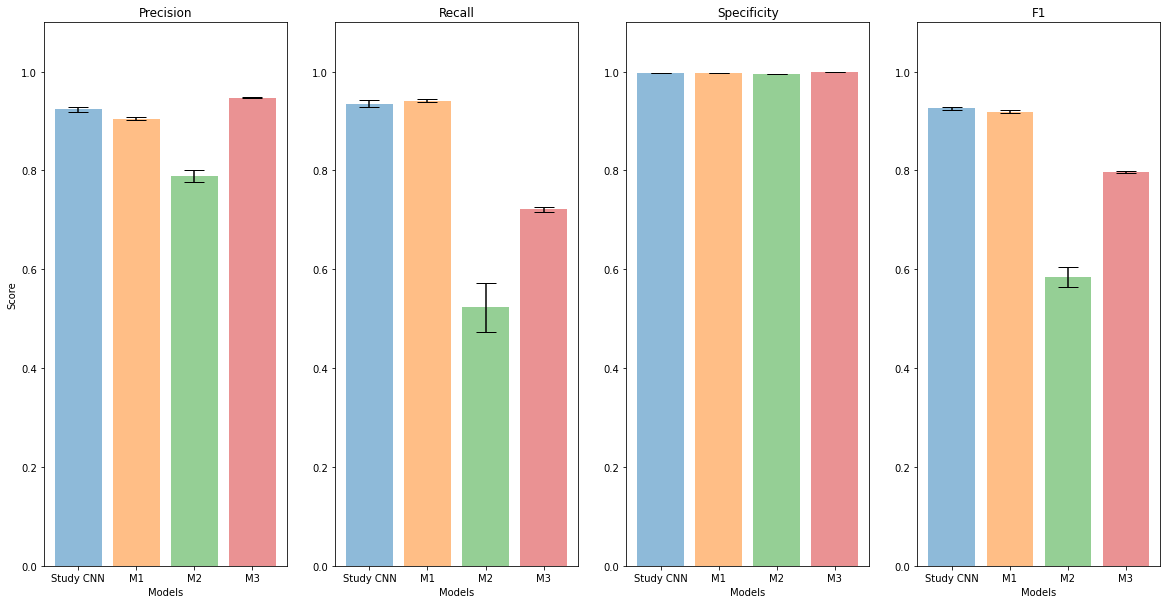

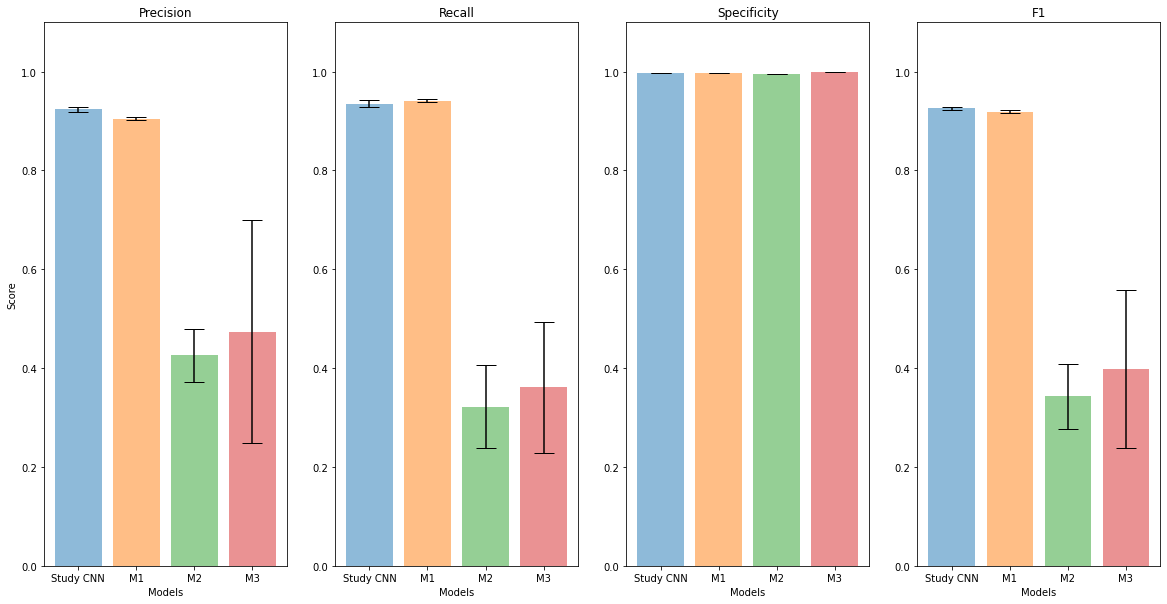

In [70]:
m1_scores_path = cwd + '\\outputs\\pickleFiles\\m1_scores.pickle'
m2_scores_path = cwd + '\\outputs\\pickleFiles\\m2_scores.pickle'
m3_scores_path = cwd + '\\outputs\\pickleFiles\\m3_scores.pickle'

def ProcessScores(scores: dict, save_path: str, save_path_zero_inc:str):

    avg_scores = Score_initator(filler=dict())
    avg_scores_zero_inc = Score_initator(filler=dict())
    for sub_metric in avg_scores.keys():
        for ii, cardiac_class in enumerate(avg_scores[sub_metric].keys()):
            sub_score = scores[sub_metric][cardiac_class]
            avg_scores_zero_inc[sub_metric][cardiac_class] = {'Average': np.nanmean(sub_score),\
                'Var': np.nanvar(sub_score)}
            sub_score[sub_score == 0.0] = np.NaN
            avg_scores[sub_metric][cardiac_class] = {'Average': np.nanmean(sub_score),\
                'Var': np.nanvar(sub_score)}

    score_output = pd.DataFrame.from_dict({(i,j): avg_scores[i][j]
                           for i in avg_scores.keys() 
                           for j in avg_scores[i].keys()},
                       orient='index')
    
    score_output_zero_inc = pd.DataFrame.from_dict({(i,j): avg_scores_zero_inc[i][j]
                           for i in avg_scores_zero_inc.keys() 
                           for j in avg_scores_zero_inc[i].keys()},
                       orient='index')

    score_output.to_csv(save_path)
    score_output_zero_inc.to_csv(save_path_zero_inc)

    test = score_output.to_numpy()

    score_1 = np.array([[np.nanmean(score_output.to_numpy()[ii:ii+6,0], axis = 0), np.nanvar(score_output.to_numpy()[ii:ii+6,0], axis = 0)] \
        for ii in range(0,score_output.to_numpy().shape[0],6)])
    score_2 = np.array([[np.nanmean(score_output_zero_inc.to_numpy()[ii:ii+6,0], axis = 0), np.nanvar(score_output_zero_inc.to_numpy()[ii:ii+6,0], axis = 0)] \
        for ii in range(0,score_output_zero_inc.to_numpy().shape[0],6)])

    return score_1, score_2


def PlotScores(models: list, m1_scores: np.ndarray, m2_scores: np.ndarray, m3_scores: np.ndarray, metric_names):

    paper_avg = [1,0.924,0.935,0.997,0.926]
    paper_var = [0,0.005,0.007,0.000,0.003]

    fig, axs = plt.subplots(1,4, figsize = (20,10), sharex = True)
    for ii in range(m1_scores.shape[0]):
        if ii == 0:
            continue

        axs[ii-1].bar(models[0], paper_avg[ii], 
            yerr=paper_var[ii], align='center',
            alpha=0.5, ecolor='black',
            capsize=10)
        axs[ii-1].bar(models[1], m1_scores[ii,0], 
            yerr=m1_scores[ii,1], align='center',
            alpha=0.5, ecolor='black',
            capsize=10)
        axs[ii-1].bar(models[2], m2_scores[ii,0], 
            yerr=m2_scores[ii,1], align='center',
            alpha=0.5, ecolor='black',
            capsize=10)
        axs[ii-1].bar(models[3], m3_scores[ii,0], 
            yerr=m3_scores[ii,1], align='center',
            alpha=0.5, ecolor='black',
            capsize=10)
        axs[ii-1].set_title(metric_names[ii])
        axs[ii-1].set_ylim(0, 1.1)
        if ii == 1:
            axs[ii-1].set_ylabel('Score')
        axs[ii-1].set_xlabel('Models')

m1_scores = LoadObject(m1_scores_path)
m2_scores = LoadObject(m2_scores_path)
m3_scores = LoadObject(m3_scores_path)

m1_avg_scores, m1_avg_scores_zero_div = ProcessScores(m1_scores, cwd + '\\outputs\\csvFiles\\m1_scores.csv',\
    cwd + '\\outputs\\csvFiles\\m1_scores_zero_div.csv')
m2_avg_scores, m2_avg_scores_zero_div = ProcessScores(m2_scores, cwd + '\\outputs\\csvFiles\\m2_scores.csv',\
    cwd + '\\outputs\\csvFiles\\m2_scores_zero_div.csv')
m3_avg_scores, m3_avg_scores_zero_div = ProcessScores(m3_scores, cwd + '\\outputs\\csvFiles\\m3_scores.csv',\
    cwd + '\\outputs\\csvFiles\\m3_scores_zero_div.csv')


models = ['Study CNN','M1','M2','M3']

PlotScores(models, m1_avg_scores, m2_avg_scores, m3_avg_scores, metric_names=list(m1_scores.keys()))
PlotScores(models, m1_avg_scores_zero_div, m2_avg_scores_zero_div, m3_avg_scores_zero_div, metric_names=list(m1_scores.keys()))



**Process Times**



In [69]:
time_path = cwd + '\\outputs\\pickleFiles\\time.pickle'
time_tracking = LoadObject(time_path)

formatted_dict = {'Model 1': [np.NaN, np.mean(time_tracking['M1_pred_time'])],\
    'Model 2': [np.mean(time_tracking['M2_train_time']), np.mean(time_tracking['M2_pred_time'])],\
    'Model 3': [np.mean(time_tracking['M3_train_time']), np.mean(time_tracking['M3_pred_time'])]}

formatted_times = pd.DataFrame(formatted_dict, index=['Train Time [s]', 'Prediction Time [s]'])

formatted_times.to_csv(cwd + '\\outputs\\csvFiles\\time.csv')
print(formatted_times)

                      Model 1      Model 2   Model 3
Train Time [s]            NaN  2183.953105  4.066791
Prediction Time [s]  2.853524     3.155539  0.098946
